In [ ]:
!pip install opencv-python

In [135]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt 



In [144]:
!nvidia-smi

Mon Sep 14 08:41:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   8803MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

30.0
AxesImage(54,36;334.8x217.44)
(3630, 128, 171, 3)


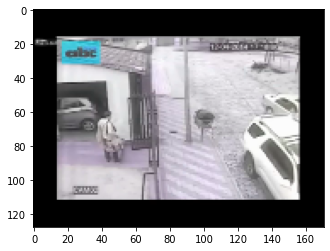

In [136]:
# resize video size, frame rate fix to 30
resize_width = 171
resize_height = 128
clip_len = 16
crop_size = 112
frames = []
fpss = []


cap = cv2.VideoCapture('Shooting033_x264.mp4')
# retval= cv.VideoCapture.set(5,value)
# cap.set(CAP_PROP_FPS, 30)
while cap.isOpened():
    # print('오픈')
    ret, frame = cap.read()
    if ret:
        # print('resize')
        frame = cv2.resize(frame, (resize_width, resize_height))
        frames.append(frame)
        fps = cap.get(5) 
        
    else:
        cap.release()
        break

print(fps)

print(plt.imshow(frames[0]))
frame_count = len(frames)
buffer = np.empty((frame_count, resize_height, resize_width, 3), np.dtype('float32'))

for i, frame_name in enumerate(frames):
    frame = np.array(frame_name).astype(np.float64)
    buffer[i] = frame

print(buffer.shape)



In [ ]:
#crop <-crop: 스캐너 등을 거쳐 입력한 사진 등의 화상은 화상의 윤곽이 
#거친 경우가 많기 때문에 이것을 다듬는 것 등을 말하는데, 컴퓨터 그래픽에 있어서 그래픽 화상의 일부분을 잘라내어 섬세한 화상을 만드는 작업
#그런거같아요 픽셀맞추는것 보단 더 선명하게 다듬는 그런느낌이긴해요 자세히는 모르겠는데 c3d작업할때 crop작업을 다 하더라구요 그 이미지 전처리 단계에서 하는거같아요
#네네 그쵸 원래는 crop하고 nomalize 하고 tensor화 해야하는데 normalize가 빠져있어요

clip_len = 16
resize_height = 128
resize_width = 171
crop_size = 112

time_index = np.random.randint(buffer.shape[0] - clip_len)
height_index = np.random.randint(buffer.shape[1] - crop_size)
width_index = np.random.randint(buffer.shape[2] - crop_size)

buffer = buffer[time_index:time_index + clip_len, height_index:height_index + crop_size, width_index:width_index + crop_size, :]

print(buffer.shape)
print(buffer[0])
for i, frame in enumerate(buffer):
    frame = frame / 255.0
    buffer[i] = frame
print(buffer[0])

In [138]:
# add dimension
# 텐서화 하고 모델에 넣기 위해서 디멘전 ~~ 추가해줬어요
import tensorflow as tf 

new_buffer = tf.expand_dims(buffer,0)
print(new_buffer.shape)

(1, 16, 112, 112, 3)


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.optimizers import SGD
import keras
# from keras import backend as K
# K.common.image_dim_ordering('th')
# K.set_image_dim_ordering('th')
# keras.backend.image_data_format()

model = Sequential()
model.add(Convolution3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape=(16, 112, 112, 3) ))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same', name='pool1'))

model.add(Convolution3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool2'))

model.add(Convolution3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
model.add(Convolution3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool3'))

model.add(Convolution3D(512, 3, activation='relu', padding='same', name='conv4a'))
model.add(Convolution3D(512, 3, activation='relu', padding='same', name='conv4b'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool4'))

model.add(Convolution3D(512, 3, activation='relu', padding='same', name='conv5a'))
model.add(Convolution3D(512, 3, activation='relu', padding='same', name='conv5b'))
model.add(ZeroPadding3D(padding=(0,1,1)))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='valid', name='pool5'))

model.add(Flatten())

model.add(Dense(4096, activation='relu', name='fc6'))
# model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu', name='fc7'))
# model.add(Dropout(0.5))
# model.add(Dense(487, activation='softmax', name='fc8'))
#fc7, 8 을 넣어야하나 말아야 하나 하다가 빼봤습니다 일단... 논문에서도 4096 아웃풋을 쓰는걸로알고있어서
print(model.summary())

In [ ]:
model.compile(loss='mean_squared_error', optimizer='sgd') 
output = model(new_buffer)
output

